In [1]:
import torch

# from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from PIL import Image
from tqdm import tqdm
import random
import os


In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# transform = transforms.Compose(
#     [
#         transforms.Resize((200, 200)),
#         transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomRotation(10),
#     ]
# )

transform = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


In [3]:
train_dir = "C:/Users/mbele/Desktop/AIM1 TERM 2/Deep Learning with Pytorch/Finger-spelling-classification/asl_alphabet_train"
# test_dir = "C:/Users/mbele/Desktop/AIM1 TERM 2/Deep Learning with Pytorch/Project/asl_alphabet_test"


In [4]:
train_ds = datasets.ImageFolder(root=train_dir, transform=transform)
labels = train_ds.classes


In [5]:
# dict = {"image":img, 'label':labels}
# pd.DataFrame(img, labels, columns=["image", "labels"])


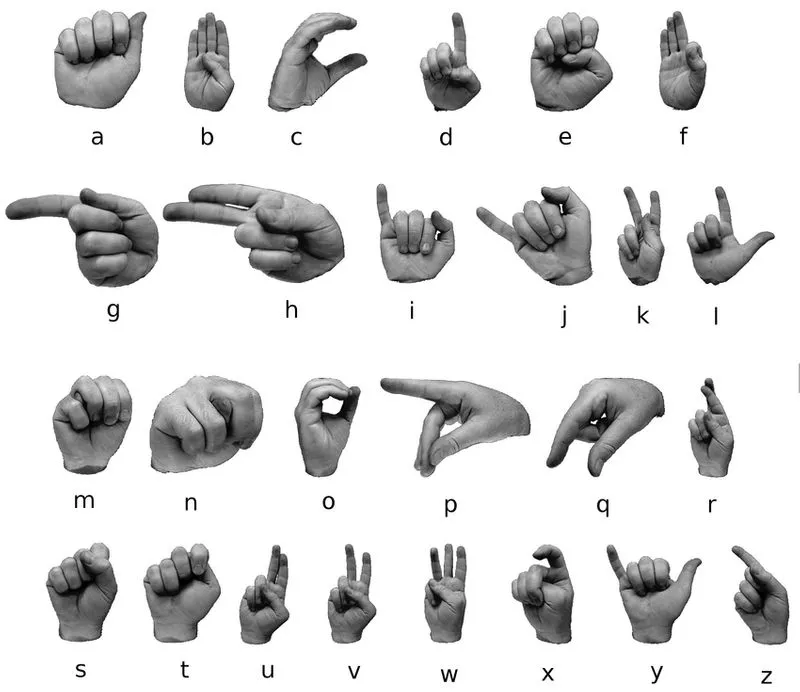


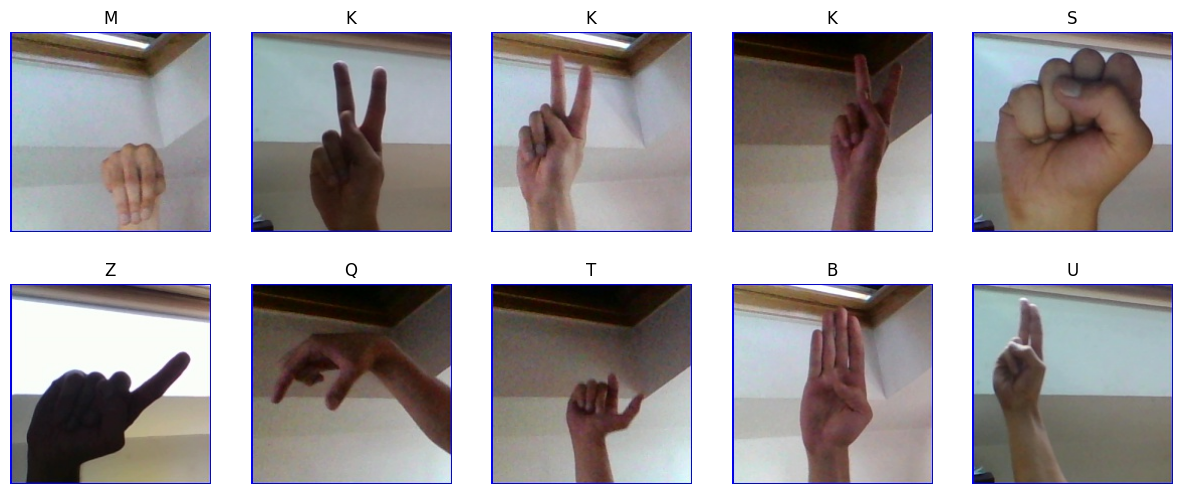

In [6]:
# for item in train_ds.samples:
#     img = Image.open(item[0])
#     plt.imshow(img)

rows = 2
cols = 5
fig, axes = plt.subplots(rows, cols, figsize=(15, 6))
axes = axes.flatten()

for ax in axes:
    index = random.randint(0, len(train_ds.samples))
    ax.axis("off")
    img_path = train_ds.samples[index][0]
    img = Image.open(img_path)
    ax.set_title(f"{labels[train_ds.samples[index][1]]}")
    ax.imshow(img)
    # plt.show()


## Splitting data into train and validation sets


#### taking a subset of dataset


In [7]:
# from torch.utils.data import DataLoader, Subset
# from torchvision import datasets, transforms
# import numpy as np

# # batch_size = 128

# train_ds = datasets.ImageFolder(root=train_dir, transform=transform)

# samples_per_class = 2000  # number of samples

# class_indices = {}
# for idx, (data, label) in enumerate(train_ds):
#     if label not in class_indices:
#         class_indices[label] = []
#     class_indices[label].append(idx)

# subset_indices = []
# for label, indices in class_indices.items():
#     if len(indices) < samples_per_class:
#         raise ValueError(
#             f"Not enough samples in class {label} to satisfy samples_per_class={samples_per_class}"
#         )
#     subset_indices.extend(np.random.choice(indices, samples_per_class, replace=False))

# subset_ds = Subset(train_ds, subset_indices)

# subset_loader = DataLoader(subset_ds, batch_size=batch_size, shuffle=True)


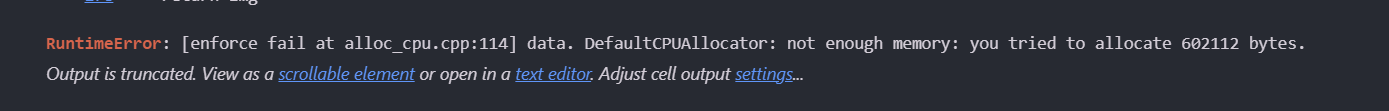


In [8]:
train_val, test_set = train_test_split(
    train_ds,
    test_size=0.2,
    shuffle=True,
    # stratify=[train_ds.targets[i] for i in range(num_samples)], # just testing it out
)

train_set, val_set = train_test_split(
    train_val,
    test_size=0.3,
    shuffle=True,
)
print(f"Train: {len(train_set)}\nVal: {len(val_set)}\nTest: {len(test_set)}")


Train: 48720
Val: 20880
Test: 17400


In [9]:
batch_size = 28

trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_set, batch_size=batch_size)
# for image, label in testloader:
#     print(image.shape, label.shape)


## Building model


## using pretrained network (RESNET18)


In [10]:
# model = models.resnet18(pretrained=True)
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 29)  # since there are 29 classes

# move model to GPU
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)


## Finding Best Learning rate


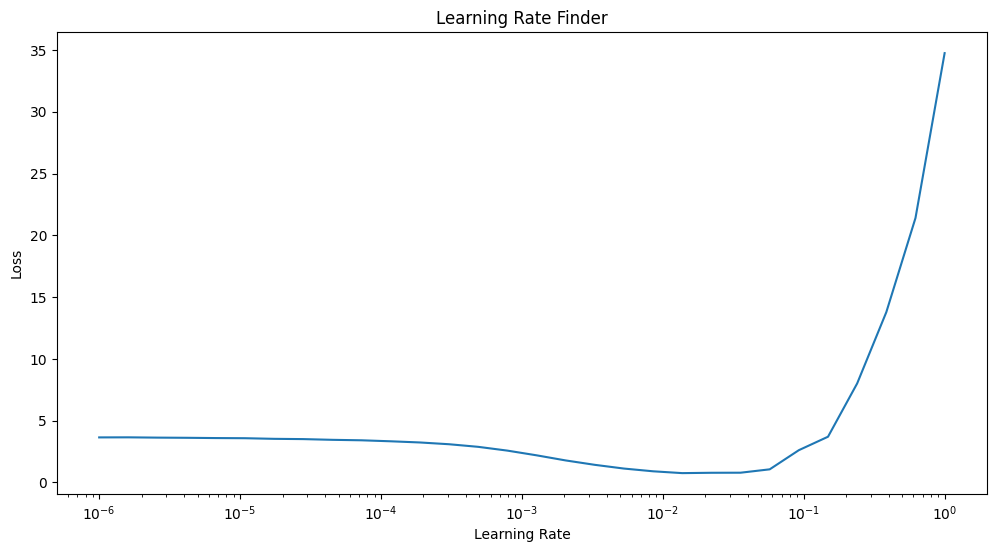

In [11]:
lrs = []
losses = []
count = 0

for lr in np.logspace(-6, 0, 30):
    optimizer = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i == 100:  # Stop early to speed up the process
            count += 1
            # print(count)
            break
    lrs.append(lr)
    losses.append(running_loss / 100)

plt.figure(figsize=(12, 6))
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()


## Training funcion


In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.fc.parameters(), lr=0.01, momentum=0.9)

train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []


def train(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0.0
        correct = 0
        total = 0
        model.train()  # Put model into train mode
        for i, data in enumerate(trainloader, 0):

            inputs, labels = data
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            # _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            train_losses.append(loss.item())
            accuracy = 100 * correct / ((i + 1) * trainloader.batch_size)
            if (i + 1) % 100 == 0:
                train_accuracy.append(accuracy)
                print(
                    f"Epoch [{epoch + 1}/{10}], Iteration [{i + 1}/{len(trainloader)}], Loss: {loss.item():.4f}, Accuracy: {accuracy:.2f}%"
                )
        correct = 0
        model.eval()
        # validation loop
        with torch.no_grad():
            for images, labels in valloader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum()
                val_losses.append(loss.item())
            accuracy = 100 * (correct.item()) / len(val_set)
            val_accuracy.append(accuracy)

    # set the model back to train mode
    model.train()

    print("Finished Training")


In [13]:
num_epochs = 10
train(model, trainloader, valloader, criterion, optimizer, num_epochs=num_epochs)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch [1/10], Iteration [100/1740], Loss: 3.2574, Accuracy: 73.43%
Epoch [1/10], Iteration [200/1740], Loss: 9.9059, Accuracy: 77.34%
Epoch [1/10], Iteration [300/1740], Loss: 18.4640, Accuracy: 79.23%
Epoch [1/10], Iteration [400/1740], Loss: 7.7303, Accuracy: 80.37%
Epoch [1/10], Iteration [500/1740], Loss: 13.7448, Accuracy: 81.04%
Epoch [1/10], Iteration [600/1740], Loss: 3.1006, Accuracy: 81.41%
Epoch [1/10], Iteration [700/1740], Loss: 14.9226, Accuracy: 81.85%
Epoch [1/10], Iteration [800/1740], Loss: 0.0000, Accuracy: 82.12%
Epoch [1/10], Iteration [900/1740], Loss: 2.5016, Accuracy: 82.49%
Epoch [1/10], Iteration [1000/1740], Loss: 3.2032, Accuracy: 82.76%
Epoch [1/10], Iteration [1100/1740], Loss: 13.3022, Accuracy: 83.09%
Epoch [1/10], Iteration [1200/1740], Loss: 6.0752, Accuracy: 83.34%
Epoch [1/10], Iteration [1300/1740], Loss: 7.3310, Accuracy: 83.55%
Epoch [1/10], Iteration [1400/1740], Loss: 2.9607, Accuracy: 83.71%
Epoch [1/10], Iteration [1500/1740], Loss: 6.9881, Ac

 10%|█         | 1/10 [01:52<16:48, 112.07s/it]

Epoch [2/10], Iteration [100/1740], Loss: 2.4675, Accuracy: 87.61%
Epoch [2/10], Iteration [200/1740], Loss: 2.3979, Accuracy: 87.36%
Epoch [2/10], Iteration [300/1740], Loss: 0.4853, Accuracy: 87.64%
Epoch [2/10], Iteration [400/1740], Loss: 0.7188, Accuracy: 87.39%
Epoch [2/10], Iteration [500/1740], Loss: 5.0361, Accuracy: 87.37%
Epoch [2/10], Iteration [600/1740], Loss: 9.5960, Accuracy: 87.40%
Epoch [2/10], Iteration [700/1740], Loss: 2.3600, Accuracy: 87.45%
Epoch [2/10], Iteration [800/1740], Loss: 8.0968, Accuracy: 87.44%
Epoch [2/10], Iteration [900/1740], Loss: 3.7001, Accuracy: 87.54%
Epoch [2/10], Iteration [1000/1740], Loss: 0.6507, Accuracy: 87.47%
Epoch [2/10], Iteration [1100/1740], Loss: 6.2059, Accuracy: 87.55%
Epoch [2/10], Iteration [1200/1740], Loss: 7.8835, Accuracy: 87.50%
Epoch [2/10], Iteration [1300/1740], Loss: 3.8474, Accuracy: 87.49%
Epoch [2/10], Iteration [1400/1740], Loss: 2.3602, Accuracy: 87.59%
Epoch [2/10], Iteration [1500/1740], Loss: 6.2867, Accura

 20%|██        | 2/10 [04:35<18:56, 142.07s/it]

Epoch [3/10], Iteration [100/1740], Loss: 3.2671, Accuracy: 88.14%
Epoch [3/10], Iteration [200/1740], Loss: 3.6023, Accuracy: 88.14%
Epoch [3/10], Iteration [300/1740], Loss: 3.4117, Accuracy: 88.30%
Epoch [3/10], Iteration [400/1740], Loss: 2.1833, Accuracy: 88.29%
Epoch [3/10], Iteration [500/1740], Loss: 4.7885, Accuracy: 88.32%
Epoch [3/10], Iteration [600/1740], Loss: 3.2209, Accuracy: 88.35%
Epoch [3/10], Iteration [700/1740], Loss: 1.9592, Accuracy: 88.43%
Epoch [3/10], Iteration [800/1740], Loss: 1.6169, Accuracy: 88.55%
Epoch [3/10], Iteration [900/1740], Loss: 1.8590, Accuracy: 88.54%
Epoch [3/10], Iteration [1000/1740], Loss: 1.1403, Accuracy: 88.61%
Epoch [3/10], Iteration [1100/1740], Loss: 7.1039, Accuracy: 88.57%
Epoch [3/10], Iteration [1200/1740], Loss: 2.8546, Accuracy: 88.58%
Epoch [3/10], Iteration [1300/1740], Loss: 4.4526, Accuracy: 88.68%
Epoch [3/10], Iteration [1400/1740], Loss: 1.4544, Accuracy: 88.70%
Epoch [3/10], Iteration [1500/1740], Loss: 2.2575, Accura

 30%|███       | 3/10 [07:28<18:13, 156.17s/it]

Epoch [4/10], Iteration [100/1740], Loss: 1.3149, Accuracy: 89.64%
Epoch [4/10], Iteration [200/1740], Loss: 5.7654, Accuracy: 89.39%
Epoch [4/10], Iteration [300/1740], Loss: 8.3378, Accuracy: 89.19%
Epoch [4/10], Iteration [400/1740], Loss: 13.5277, Accuracy: 89.26%
Epoch [4/10], Iteration [500/1740], Loss: 1.9664, Accuracy: 89.24%
Epoch [4/10], Iteration [600/1740], Loss: 4.0085, Accuracy: 89.24%
Epoch [4/10], Iteration [700/1740], Loss: 0.5772, Accuracy: 89.35%
Epoch [4/10], Iteration [800/1740], Loss: 3.7589, Accuracy: 89.41%
Epoch [4/10], Iteration [900/1740], Loss: 7.2753, Accuracy: 89.38%
Epoch [4/10], Iteration [1000/1740], Loss: 2.7279, Accuracy: 89.35%
Epoch [4/10], Iteration [1100/1740], Loss: 0.3904, Accuracy: 89.38%
Epoch [4/10], Iteration [1200/1740], Loss: 2.0811, Accuracy: 89.40%
Epoch [4/10], Iteration [1300/1740], Loss: 3.8244, Accuracy: 89.40%
Epoch [4/10], Iteration [1400/1740], Loss: 1.6923, Accuracy: 89.48%
Epoch [4/10], Iteration [1500/1740], Loss: 0.9857, Accur

 40%|████      | 4/10 [10:04<15:38, 156.34s/it]

Epoch [5/10], Iteration [100/1740], Loss: 3.3225, Accuracy: 90.36%
Epoch [5/10], Iteration [200/1740], Loss: 2.9339, Accuracy: 90.43%
Epoch [5/10], Iteration [300/1740], Loss: 0.0714, Accuracy: 90.25%
Epoch [5/10], Iteration [400/1740], Loss: 5.1574, Accuracy: 90.23%
Epoch [5/10], Iteration [500/1740], Loss: 2.3341, Accuracy: 90.29%
Epoch [5/10], Iteration [600/1740], Loss: 2.1444, Accuracy: 90.26%
Epoch [5/10], Iteration [700/1740], Loss: 3.5798, Accuracy: 90.30%
Epoch [5/10], Iteration [800/1740], Loss: 7.1880, Accuracy: 90.24%
Epoch [5/10], Iteration [900/1740], Loss: 10.7148, Accuracy: 90.21%
Epoch [5/10], Iteration [1000/1740], Loss: 0.5174, Accuracy: 90.30%
Epoch [5/10], Iteration [1100/1740], Loss: 0.2984, Accuracy: 90.39%
Epoch [5/10], Iteration [1200/1740], Loss: 4.6043, Accuracy: 90.42%
Epoch [5/10], Iteration [1300/1740], Loss: 3.7914, Accuracy: 90.41%
Epoch [5/10], Iteration [1400/1740], Loss: 2.1639, Accuracy: 90.38%
Epoch [5/10], Iteration [1500/1740], Loss: 3.3989, Accur

 50%|█████     | 5/10 [12:42<13:04, 156.92s/it]

Epoch [6/10], Iteration [100/1740], Loss: 10.6013, Accuracy: 91.29%
Epoch [6/10], Iteration [200/1740], Loss: 1.4159, Accuracy: 91.41%
Epoch [6/10], Iteration [300/1740], Loss: 3.7633, Accuracy: 91.42%
Epoch [6/10], Iteration [400/1740], Loss: 2.0495, Accuracy: 91.11%
Epoch [6/10], Iteration [500/1740], Loss: 3.1279, Accuracy: 91.21%
Epoch [6/10], Iteration [600/1740], Loss: 8.9194, Accuracy: 91.24%
Epoch [6/10], Iteration [700/1740], Loss: 1.2356, Accuracy: 91.09%
Epoch [6/10], Iteration [800/1740], Loss: 9.9861, Accuracy: 91.12%
Epoch [6/10], Iteration [900/1740], Loss: 8.4323, Accuracy: 91.12%
Epoch [6/10], Iteration [1000/1740], Loss: 6.9217, Accuracy: 91.14%
Epoch [6/10], Iteration [1100/1740], Loss: 0.0003, Accuracy: 91.20%
Epoch [6/10], Iteration [1200/1740], Loss: 4.4589, Accuracy: 91.16%
Epoch [6/10], Iteration [1300/1740], Loss: 3.5300, Accuracy: 91.19%
Epoch [6/10], Iteration [1400/1740], Loss: 3.1872, Accuracy: 91.16%
Epoch [6/10], Iteration [1500/1740], Loss: 9.4068, Accur

 60%|██████    | 6/10 [15:25<10:35, 158.80s/it]

Epoch [7/10], Iteration [100/1740], Loss: 3.3802, Accuracy: 91.39%
Epoch [7/10], Iteration [200/1740], Loss: 2.4066, Accuracy: 90.77%
Epoch [7/10], Iteration [300/1740], Loss: 8.4981, Accuracy: 90.93%
Epoch [7/10], Iteration [400/1740], Loss: 0.6466, Accuracy: 90.98%
Epoch [7/10], Iteration [500/1740], Loss: 1.8943, Accuracy: 90.99%
Epoch [7/10], Iteration [600/1740], Loss: 0.6670, Accuracy: 91.09%
Epoch [7/10], Iteration [700/1740], Loss: 2.5474, Accuracy: 91.13%
Epoch [7/10], Iteration [800/1740], Loss: 0.3310, Accuracy: 91.15%
Epoch [7/10], Iteration [900/1740], Loss: 4.9985, Accuracy: 91.19%
Epoch [7/10], Iteration [1000/1740], Loss: 1.1838, Accuracy: 91.20%
Epoch [7/10], Iteration [1100/1740], Loss: 1.6232, Accuracy: 91.22%
Epoch [7/10], Iteration [1200/1740], Loss: 0.3302, Accuracy: 91.23%
Epoch [7/10], Iteration [1300/1740], Loss: 0.8355, Accuracy: 91.24%
Epoch [7/10], Iteration [1400/1740], Loss: 7.9342, Accuracy: 91.26%
Epoch [7/10], Iteration [1500/1740], Loss: 2.3771, Accura

 70%|███████   | 7/10 [18:09<08:01, 160.49s/it]

Epoch [8/10], Iteration [100/1740], Loss: 3.1665, Accuracy: 90.82%
Epoch [8/10], Iteration [200/1740], Loss: 1.4103, Accuracy: 91.38%
Epoch [8/10], Iteration [300/1740], Loss: 2.4057, Accuracy: 91.26%
Epoch [8/10], Iteration [400/1740], Loss: 0.7927, Accuracy: 91.41%
Epoch [8/10], Iteration [500/1740], Loss: 1.4054, Accuracy: 91.44%
Epoch [8/10], Iteration [600/1740], Loss: 12.1147, Accuracy: 91.35%
Epoch [8/10], Iteration [700/1740], Loss: 5.0318, Accuracy: 91.47%
Epoch [8/10], Iteration [800/1740], Loss: 3.3636, Accuracy: 91.32%
Epoch [8/10], Iteration [900/1740], Loss: 4.5607, Accuracy: 91.33%
Epoch [8/10], Iteration [1000/1740], Loss: 1.7517, Accuracy: 91.35%
Epoch [8/10], Iteration [1100/1740], Loss: 2.4184, Accuracy: 91.34%
Epoch [8/10], Iteration [1200/1740], Loss: 0.8399, Accuracy: 91.35%
Epoch [8/10], Iteration [1300/1740], Loss: 1.3208, Accuracy: 91.39%
Epoch [8/10], Iteration [1400/1740], Loss: 2.1657, Accuracy: 91.47%
Epoch [8/10], Iteration [1500/1740], Loss: 0.0000, Accur

 80%|████████  | 8/10 [20:48<05:20, 160.16s/it]

Epoch [9/10], Iteration [100/1740], Loss: 1.4219, Accuracy: 91.11%
Epoch [9/10], Iteration [200/1740], Loss: 1.1440, Accuracy: 91.32%
Epoch [9/10], Iteration [300/1740], Loss: 1.2285, Accuracy: 91.82%
Epoch [9/10], Iteration [400/1740], Loss: 0.8212, Accuracy: 91.70%
Epoch [9/10], Iteration [500/1740], Loss: 0.6581, Accuracy: 91.72%
Epoch [9/10], Iteration [600/1740], Loss: 5.9796, Accuracy: 91.72%
Epoch [9/10], Iteration [700/1740], Loss: 3.0906, Accuracy: 91.86%
Epoch [9/10], Iteration [800/1740], Loss: 6.0912, Accuracy: 91.87%
Epoch [9/10], Iteration [900/1740], Loss: 0.0000, Accuracy: 91.83%
Epoch [9/10], Iteration [1000/1740], Loss: 1.9866, Accuracy: 91.78%
Epoch [9/10], Iteration [1100/1740], Loss: 0.8449, Accuracy: 91.81%
Epoch [9/10], Iteration [1200/1740], Loss: 0.8283, Accuracy: 91.90%
Epoch [9/10], Iteration [1300/1740], Loss: 2.7204, Accuracy: 91.92%
Epoch [9/10], Iteration [1400/1740], Loss: 0.1581, Accuracy: 91.91%
Epoch [9/10], Iteration [1500/1740], Loss: 0.2675, Accura

 90%|█████████ | 9/10 [23:34<02:41, 161.96s/it]

Epoch [10/10], Iteration [100/1740], Loss: 9.3770, Accuracy: 91.71%
Epoch [10/10], Iteration [200/1740], Loss: 4.4048, Accuracy: 91.96%
Epoch [10/10], Iteration [300/1740], Loss: 1.6388, Accuracy: 92.52%
Epoch [10/10], Iteration [400/1740], Loss: 1.8885, Accuracy: 92.43%
Epoch [10/10], Iteration [500/1740], Loss: 0.0008, Accuracy: 92.36%
Epoch [10/10], Iteration [600/1740], Loss: 3.2508, Accuracy: 92.30%
Epoch [10/10], Iteration [700/1740], Loss: 0.4037, Accuracy: 92.27%
Epoch [10/10], Iteration [800/1740], Loss: 4.1582, Accuracy: 92.29%
Epoch [10/10], Iteration [900/1740], Loss: 1.1667, Accuracy: 92.37%
Epoch [10/10], Iteration [1000/1740], Loss: 0.7642, Accuracy: 92.36%
Epoch [10/10], Iteration [1100/1740], Loss: 4.2756, Accuracy: 92.46%
Epoch [10/10], Iteration [1200/1740], Loss: 0.7923, Accuracy: 92.45%
Epoch [10/10], Iteration [1300/1740], Loss: 1.1639, Accuracy: 92.44%
Epoch [10/10], Iteration [1400/1740], Loss: 1.0723, Accuracy: 92.44%
Epoch [10/10], Iteration [1500/1740], Loss:

100%|██████████| 10/10 [26:27<00:00, 158.71s/it]

Finished Training


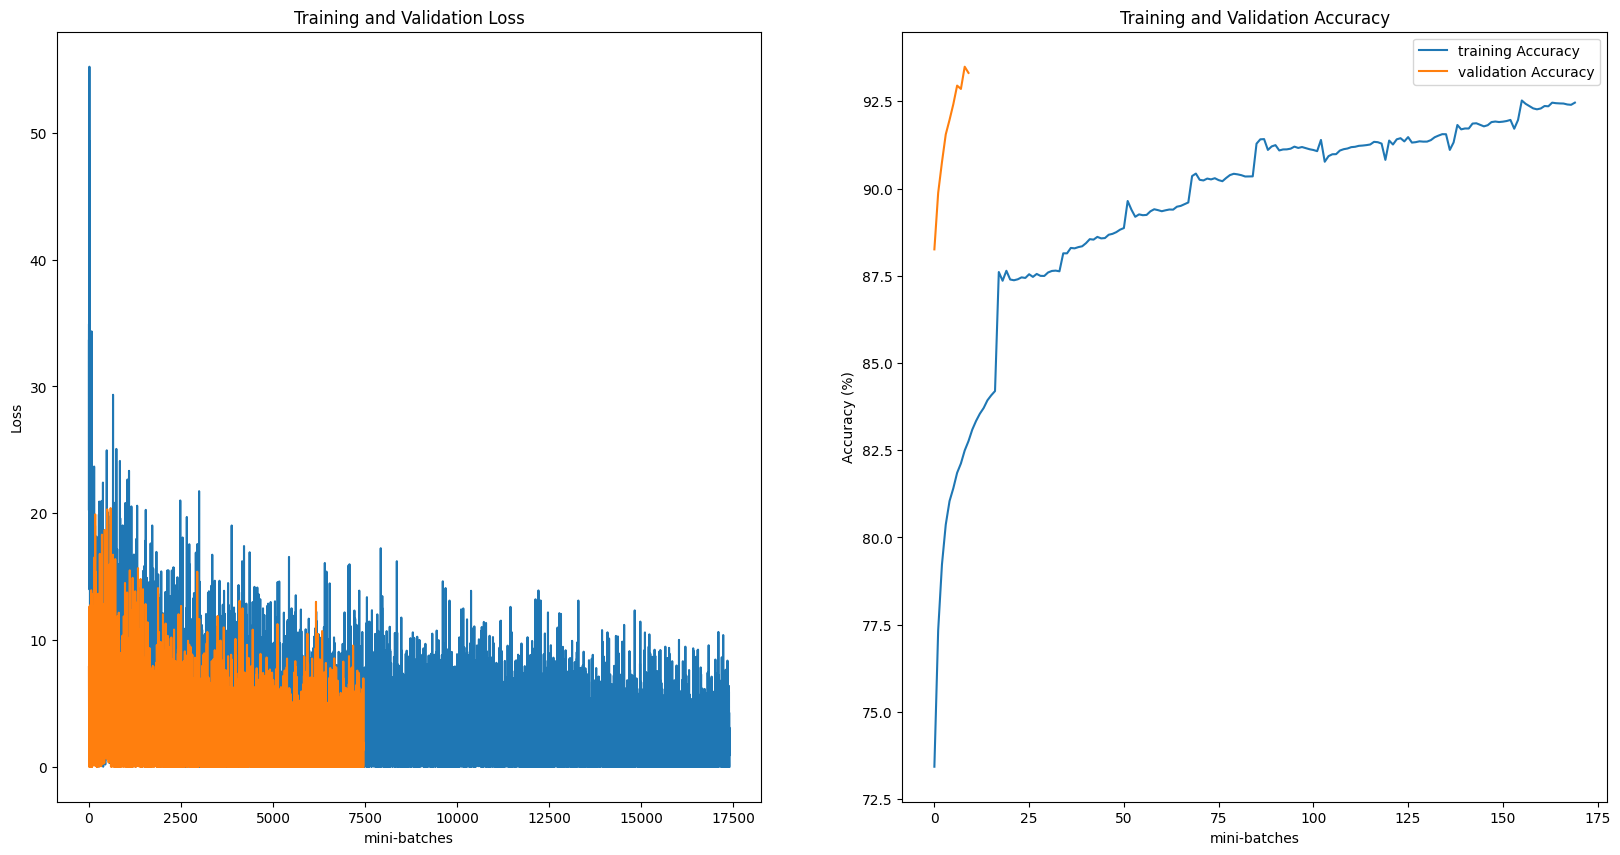

In [14]:
import matplotlib.pyplot as plt

rows = 1
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
for j in range(cols):
    if j == 0:
        axes[j].plot(train_losses, label="Train Loss")
        axes[j].plot(val_losses, label="Train Loss")
        axes[j].set_title("Training and Validation Loss")
        axes[j].set_xlabel("mini-batches")
        axes[j].set_ylabel("Loss")
    elif j == 1:
        axes[j].plot(train_accuracy, label="training Accuracy")
        axes[j].plot(val_accuracy, label="validation Accuracy")
        axes[j].set_title("Training and Validation Accuracy")
        axes[j].set_xlabel("mini-batches")
        axes[j].set_ylabel("Accuracy (%)")
plt.legend()
plt.show()


## Testing


In [15]:
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
from sklearn.metrics import accuracy_score

y_true = []
y_pred = []
model.eval()
test_correct = 0
total = 0
# Testing loop
with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # labels = labels.to(device)
        outputs = model(inputs)

        _, test_pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (test_pred == labels).sum().item()

        for idx, item in enumerate(labels):
            y_true.append(labels[idx].item())
            y_pred.append(test_pred[idx].item())


## confusion matrix


Accuracy of the network on the test images: 93.42 %


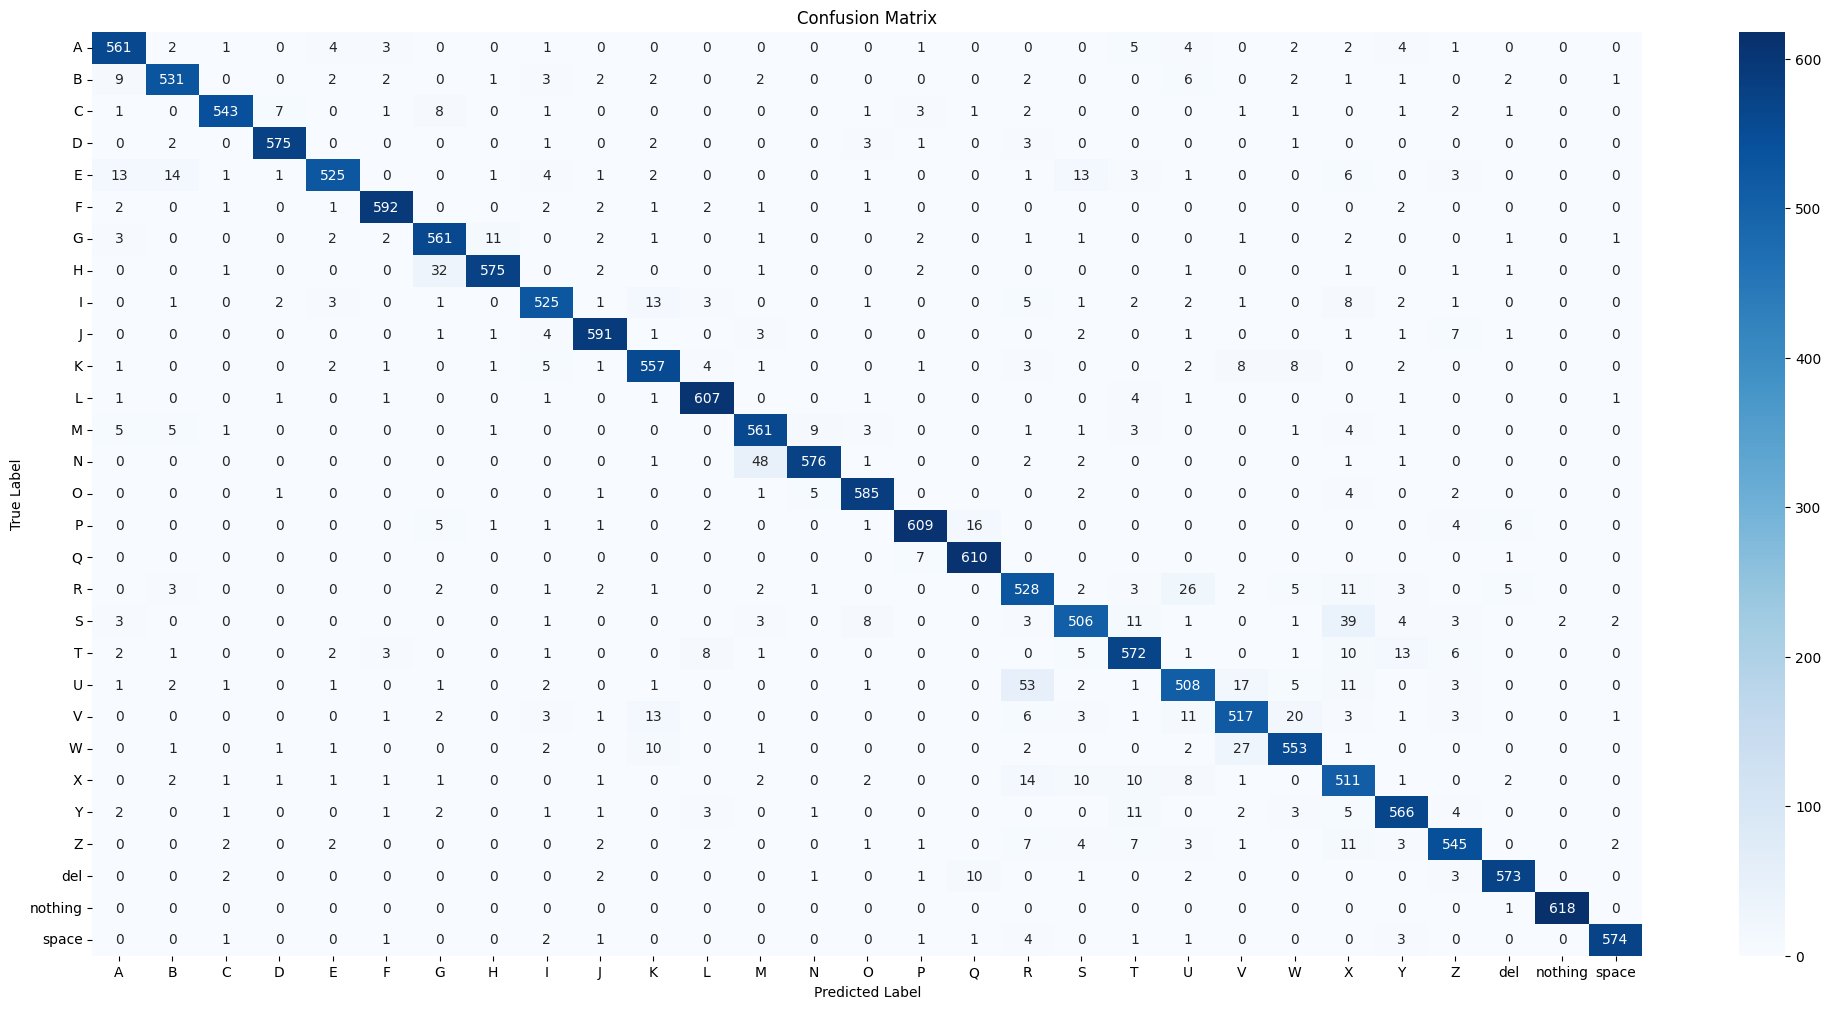

F1 Score:  0.9341954022988506


In [16]:
print(f"Accuracy of the network on the test images: {100 * test_correct / total:.2f} %")
# Find and plot confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)  # <<<<<<< your code here >>>>>>>>
plt.figure(figsize=(25, 12))
sns.heatmap(
    conf_matrix,
    annot=True,
    xticklabels=train_ds.class_to_idx.keys(),
    yticklabels=train_ds.class_to_idx.keys(),
    fmt="d",
    cmap="Blues",
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

acc = accuracy_score(y_true, y_pred, normalize=True)  # <<<<<<< your code here >>>>>>>>
print("F1 Score: ", acc)


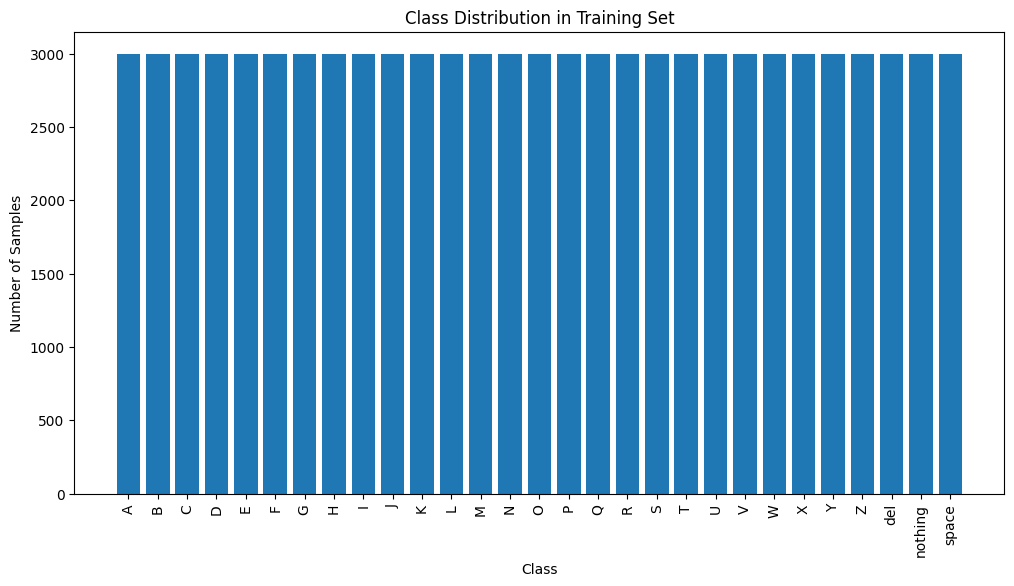

In [17]:
# class distribution
class_counts = [0] * len(train_ds.classes)
for _, label in train_ds.samples:
    class_counts[label] += 1

plt.figure(figsize=(12, 6))
plt.bar(range(len(train_ds.classes)), class_counts, tick_label=train_ds.classes)
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Set")
plt.xticks(rotation=90)
plt.show()


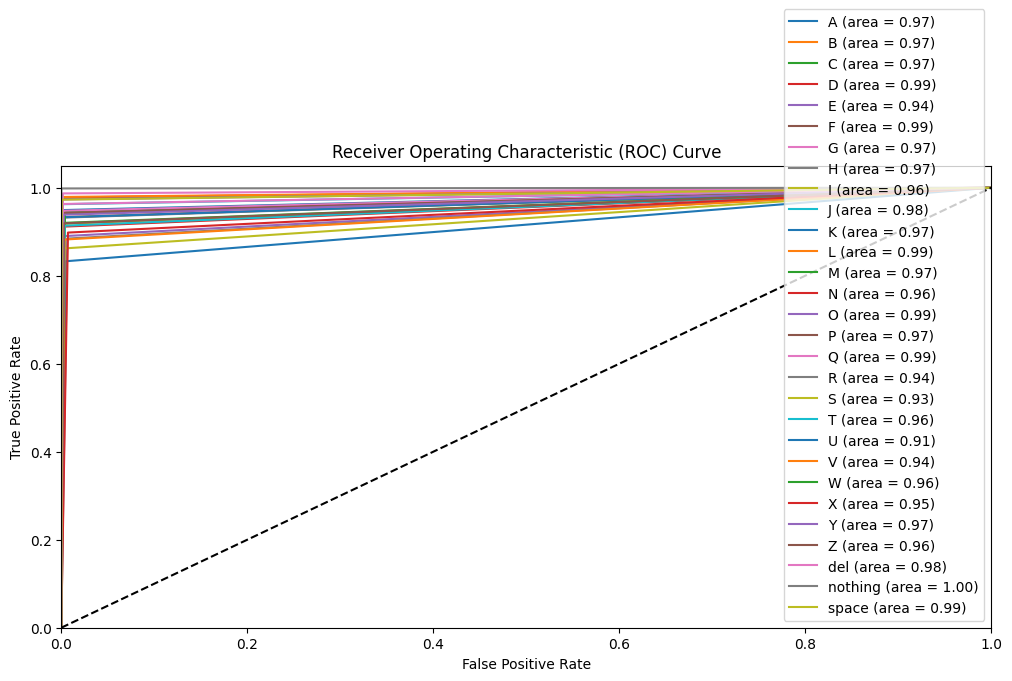

In [18]:
# target_names = train_ds.class_to_idx
# target_names

# ROC CURVE
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

y_true_bin = label_binarize(y_true, classes=range(len(train_ds.classes)))
y_pred_bin = label_binarize(y_pred, classes=range(len(train_ds.classes)))

plt.figure(figsize=(12, 6))
for i in range(len(train_ds.classes)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{train_ds.classes[i]} (area = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


Accuracy of A : 94.92%
Accuracy of B : 93.32%
Accuracy of C : 94.60%
Accuracy of D : 97.79%
Accuracy of E : 88.98%
Accuracy of F : 97.53%
Accuracy of G : 94.76%
Accuracy of H : 93.19%
Accuracy of I : 91.78%
Accuracy of J : 96.25%
Accuracy of K : 93.30%
Accuracy of L : 97.90%
Accuracy of M : 94.13%
Accuracy of N : 91.14%
Accuracy of O : 97.34%
Accuracy of P : 94.27%
Accuracy of Q : 98.71%
Accuracy of R : 88.44%
Accuracy of S : 86.20%
Accuracy of T : 91.37%
Accuracy of U : 83.28%
Accuracy of V : 88.23%
Accuracy of W : 92.01%
Accuracy of X : 89.81%
Accuracy of Y : 93.86%
Accuracy of Z : 91.91%
Accuracy of del : 96.30%
Accuracy of nothing : 99.84%
Accuracy of space : 97.29%


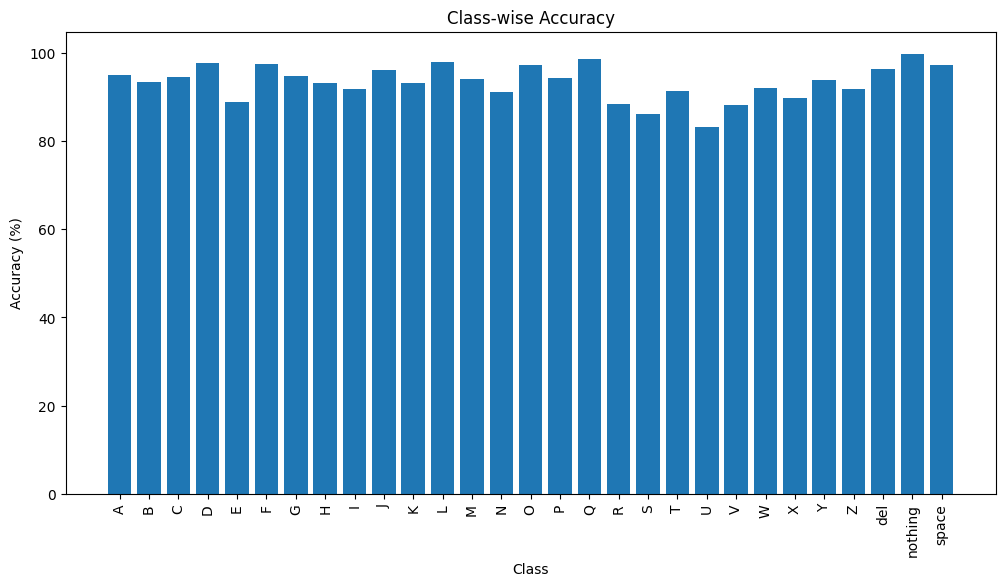

In [19]:
## class accuracies
class_correct = list(0.0 for i in range(len(train_ds.classes)))
class_total = list(0.0 for i in range(len(train_ds.classes)))

with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(train_ds.classes)):
    print(
        f"Accuracy of {train_ds.classes[i]} : {100 * class_correct[i] / class_total[i]:.2f}%"
    )

plt.figure(figsize=(12, 6))
plt.bar(
    range(len(train_ds.classes)),
    [100 * class_correct[i] / class_total[i] for i in range(len(train_ds.classes))],
)
plt.xlabel("Class")
plt.ylabel("Accuracy (%)")
plt.title("Class-wise Accuracy")
plt.xticks(range(len(train_ds.classes)), train_ds.classes, rotation=90)
plt.show()


Accuracy of the network on the test images: 93.42 %


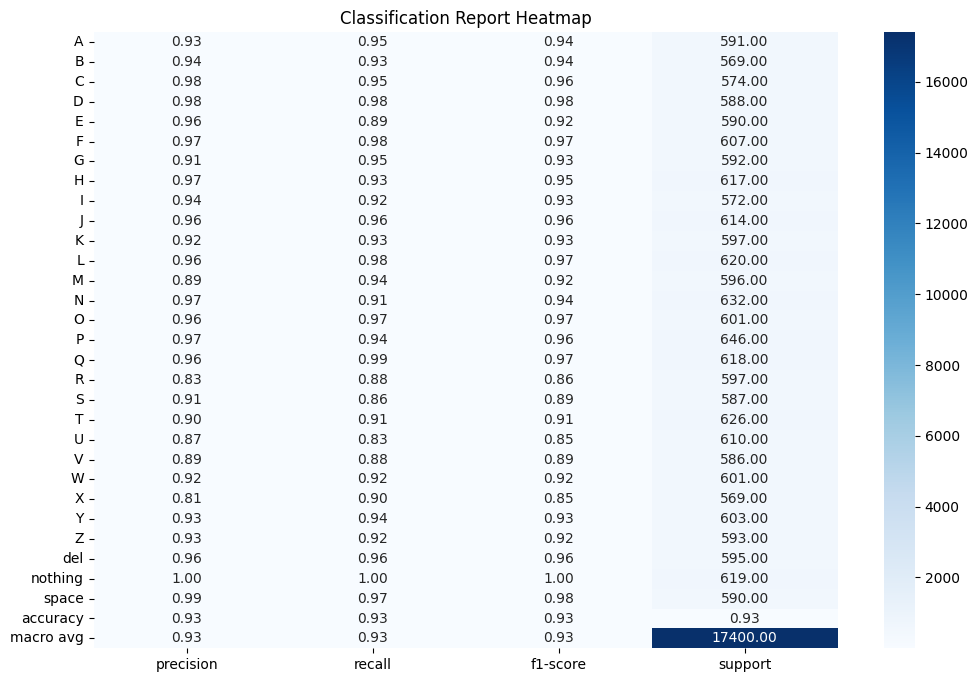

In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

# Testing loop to collect predictions and true labels
y_true = []
y_pred = []
model.eval()
test_correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, test_pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        test_correct += (test_pred == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(test_pred.cpu().numpy())

# Print test accuracy
print(f"Accuracy of the network on the test images: {100 * test_correct / total:.2f} %")

# Generate the classification report
report = classification_report(
    y_true, y_pred, target_names=[str(i) for i in train_ds.classes], output_dict=True
)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Plot the classification report as a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(report_df.iloc[:-1, :].astype(float), annot=True, cmap="Blues", fmt=".2f")
plt.title("Classification Report Heatmap")
plt.show()
